In [4]:
install.packages("dplyr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
install.packages("visdat")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [10]:
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’




In [17]:
install.packages("patchwork")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [18]:
# Создание синтетического датасета с различными проблемами
set.seed(42)
n <- 1000

# Генерация данных с проблемами
synthetic_data <- data.frame(
  age = round(rnorm(n, 35, 10)),
  income = rnorm(n, 50000, 15000),
  education = sample(c("HS", "Bachelor", "Master", "PhD", "Unknown"),
                     n, replace = TRUE, prob = c(0.3, 0.4, 0.2, 0.08, 0.02)),
  city = sample(c("New York", "Boston", "Chicago", "Los Angeles", "Miami"),
                n, replace = TRUE),
  purchase_amount = rgamma(n, shape = 2, rate = 0.01),
  # Добавляем проблемы
  age_na = ifelse(runif(n) < 0.05, NA, round(rnorm(n, 35, 10))),
  income_outliers = ifelse(runif(n) < 0.03, rnorm(n, 150000, 50000),
                           rnorm(n, 50000, 15000)),
  duplicate_flag = sample(1:200, n, replace = TRUE)  # Создаем дубликаты
)

# Добавляем дубликаты
duplicates <- synthetic_data[sample(1:n, 20), ]
synthetic_data <- rbind(synthetic_data, duplicates)

cat("Размер датасета:", dim(synthetic_data), "\n")
cat("Структура данных:\n")
str(synthetic_data)


Размер датасета: 1020 8 
Структура данных:
'data.frame':	1020 obs. of  8 variables:
 $ age            : num  49 29 39 41 39 34 50 34 55 34 ...
 $ income         : num  84876 57862 64561 55655 35061 ...
 $ education      : chr  "HS" "PhD" "Bachelor" "Master" ...
 $ city           : chr  "Los Angeles" "Chicago" "Boston" "Boston" ...
 $ purchase_amount: num  382 245 194 725 309 ...
 $ age_na         : num  NA 26 35 17 51 32 43 13 31 52 ...
 $ income_outliers: num  44399 43907 56356 65400 55072 ...
 $ duplicate_flag : int  120 69 78 61 133 133 57 178 103 38 ...


Пропущенные значения по столбцам:
            age          income       education            city purchase_amount 
              0               0               0               0               0 
         age_na income_outliers  duplicate_flag 
             57               0               0 
После обработки пропусков: 996 8 


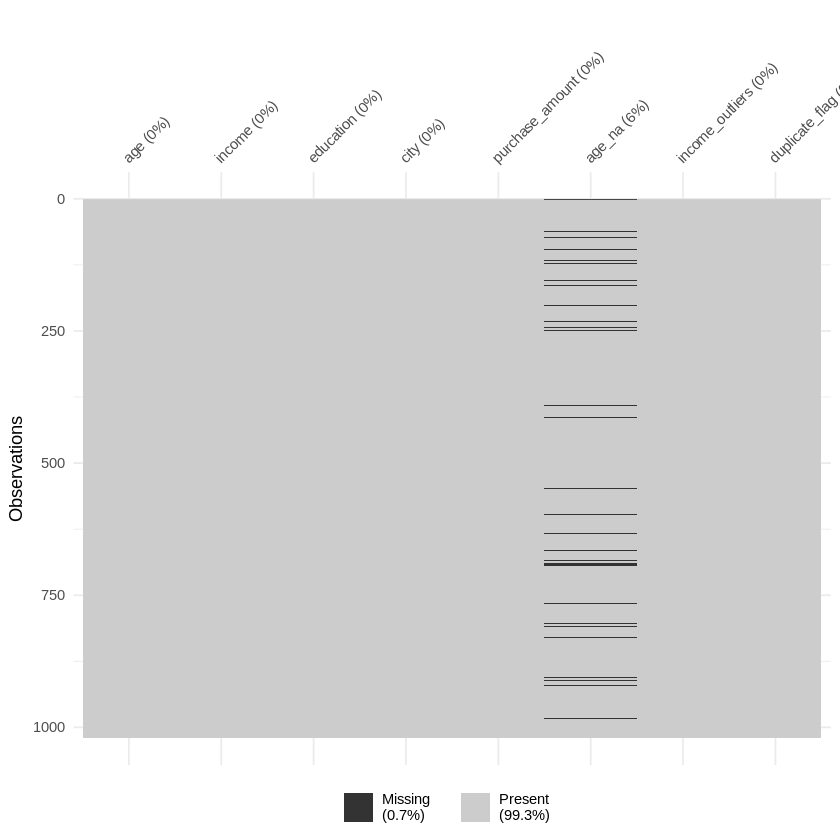

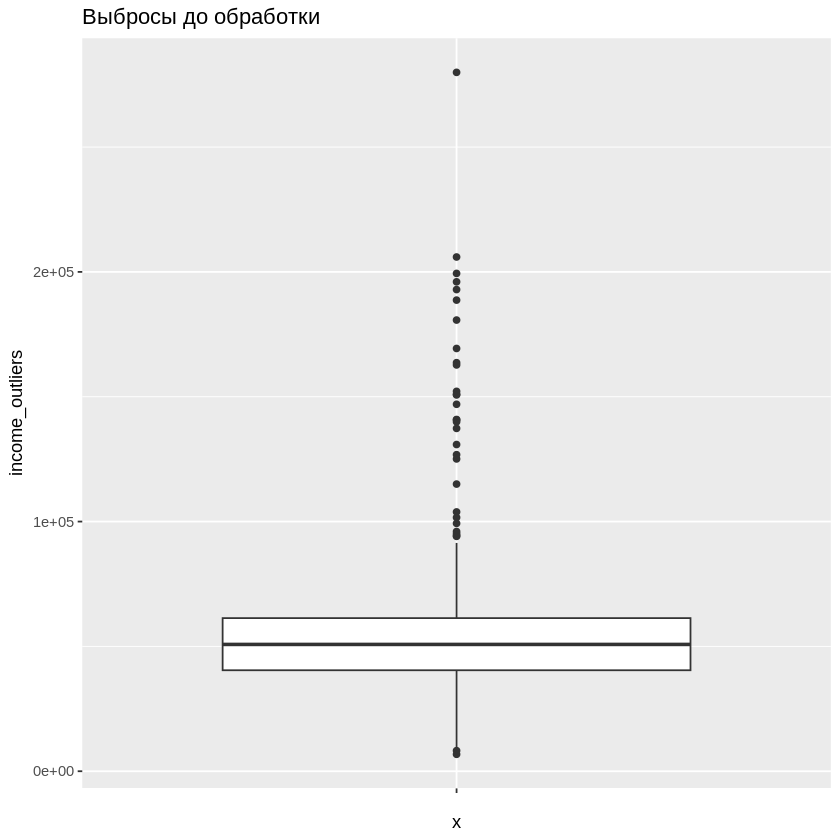

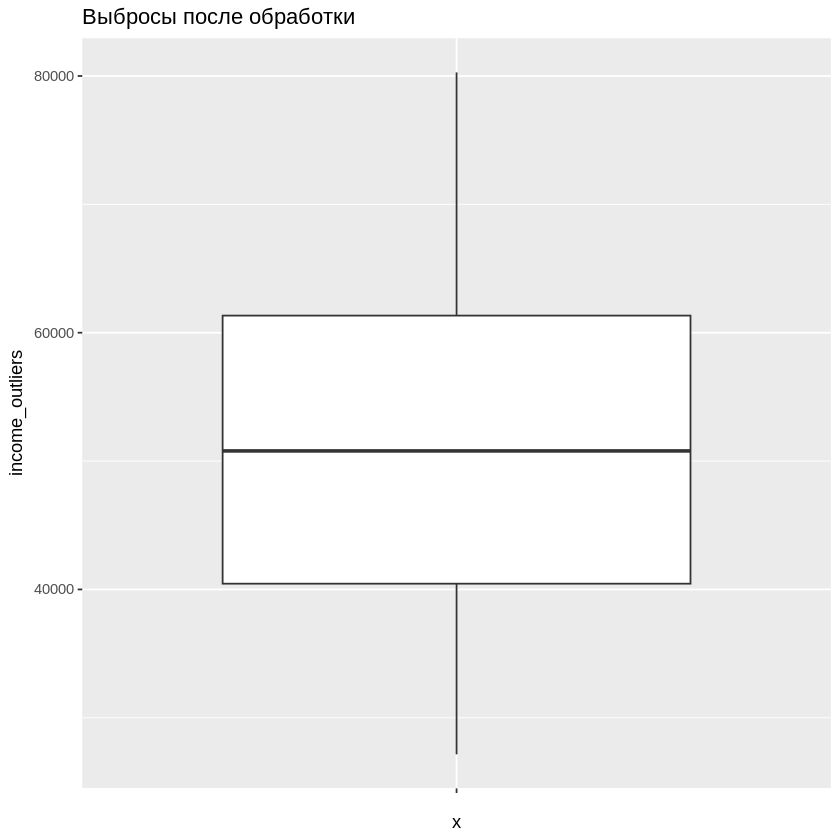

In [19]:
# 1. ОБНАРУЖЕНИЕ И ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
library(dplyr)
library(ggplot2)

# Анализ пропущенных значений
missing_analysis <- function(data) {
  cat("Пропущенные значения по столбцам:\n")
  print(colSums(is.na(data)))

  # Визуализация пропущенных значений
  library(visdat)
  vis_miss(data)
}

missing_analysis(synthetic_data)

# Заполнение пропущенных значений
clean_data <- synthetic_data %>%
  mutate(
    age_na = ifelse(is.na(age_na), median(age_na, na.rm = TRUE), age_na),
    education = ifelse(education == "Unknown", NA, education)
  ) %>%
  tidyr::drop_na(education)  # Удаляем строки с пропусками в education

cat("После обработки пропусков:", dim(clean_data), "\n")

# 2. ОБРАБОТКА ВЫБРОСОВ
handle_outliers <- function(data) {
  # Метод IQR для обнаружения выбросов
  identify_outliers <- function(x) {
    Q1 <- quantile(x, 0.25, na.rm = TRUE)
    Q3 <- quantile(x, 0.75, na.rm = TRUE)
    IQR <- Q3 - Q1
    lower_bound <- Q1 - 1.5 * IQR
    upper_bound <- Q3 + 1.5 * IQR
    x < lower_bound | x > upper_bound
  }

  # Визуализация выбросов до обработки
  p1 <- ggplot(data, aes(x = "", y = income_outliers)) +
    geom_boxplot() +
    labs(title = "Выбросы до обработки")

  # Обработка выбросов - winsorization
  winsorize <- function(x, limits = c(0.05, 0.95)) {
    x_quantiles <- quantile(x, limits, na.rm = TRUE)
    x[x < x_quantiles[1]] <- x_quantiles[1]
    x[x > x_quantiles[2]] <- x_quantiles[2]
    return(x)
  }

  data$income_outliers <- winsorize(data$income_outliers)

  p2 <- ggplot(data, aes(x = "", y = income_outliers)) +
    geom_boxplot() +
    labs(title = "Выбросы после обработки")

  print(p1)
  print(p2)

  return(data)
}

clean_data <- handle_outliers(clean_data)

In [20]:
# 3. УДАЛЕНИЕ ДУБЛИКАТОВ
cat("Дубликатов до удаления:", sum(duplicated(clean_data)), "\n")

clean_data <- clean_data %>%
  distinct()  # Удаляем полные дубликаты

# Удаляем дубликаты по ключевым полям
clean_data <- clean_data %>%
  distinct(age, income, education, city, .keep_all = TRUE)

cat("Дубликатов после удаления:", sum(duplicated(clean_data)), "\n")
cat("Размер после удаления дубликатов:", dim(clean_data), "\n")


Дубликатов до удаления: 19 
Дубликатов после удаления: 0 
Размер после удаления дубликатов: 977 8 


In [21]:
# 4. КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ
encode_categorical <- function(data) {
  # One-Hot Encoding для номинальных переменных
  library(caret)
  dummy <- dummyVars(~ city + education, data = data)
  encoded_data <- predict(dummy, newdata = data) %>% as.data.frame()

  # Объединяем с исходными данными
  final_data <- cbind(data %>% select(-city, -education), encoded_data)

  cat("Размер после кодирования:", dim(final_data), "\n")

  return(final_data)
}

clean_data_encoded <- encode_categorical(clean_data)


Размер после кодирования: 977 15 


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


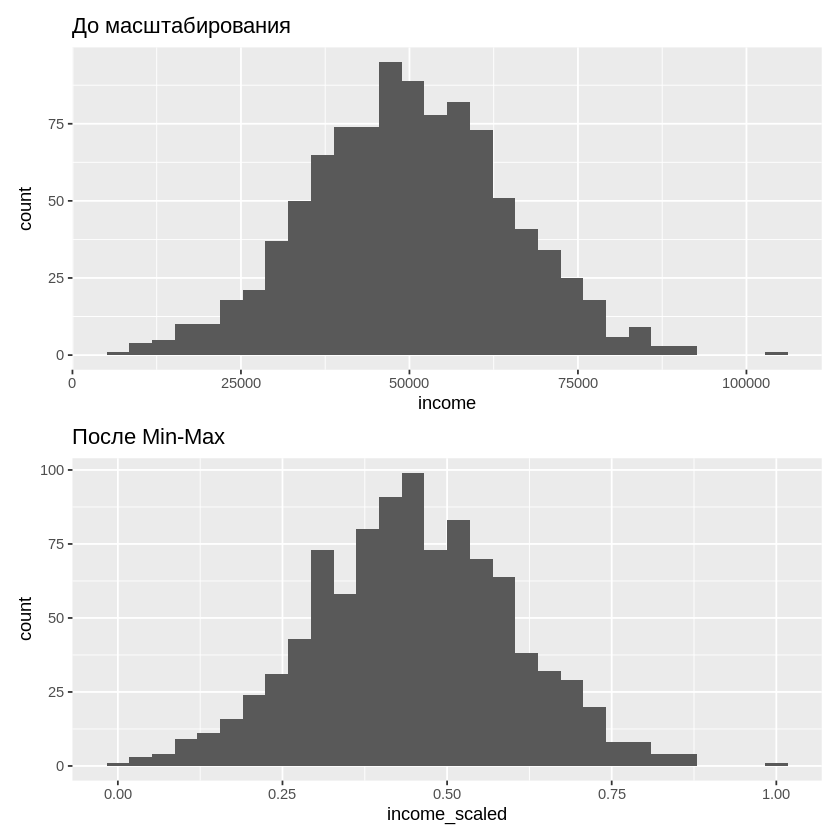

In [22]:
# 5. МАСШТАБИРОВАНИЕ ЧИСЛОВЫХ ПЕРЕМЕННЫХ
scale_features <- function(data) {
  # Min-Max scaling
  min_max_scale <- function(x) {
    (x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE))
  }

  # Z-score standardization
  z_score_scale <- function(x) {
    (x - mean(x, na.rm = TRUE)) / sd(x, na.rm = TRUE)
  }

  data_scaled <- data %>%
    mutate(
      income_scaled = min_max_scale(income),
      purchase_scaled = z_score_scale(purchase_amount),
      age_scaled = min_max_scale(age)
    )

  # Визуализация результатов масштабирования
  library(patchwork)
  p1 <- ggplot(data, aes(x = income)) + geom_histogram() + ggtitle("До масштабирования")
  p2 <- ggplot(data_scaled, aes(x = income_scaled)) + geom_histogram() + ggtitle("После Min-Max")

  print(p1 / p2)

  return(data_scaled)
}

final_data <- scale_features(clean_data_encoded)


In [23]:
# 6. ФИНАЛЬНАЯ ПРОВЕРКА И СОХРАНЕНИЕ
# Проверка качества предобработки
cat("\n=== ФИНАЛЬНАЯ ПРОВЕРКА ===\n")
cat("Пропущенные значения:", sum(is.na(final_data)), "\n")
cat("Дубликаты:", sum(duplicated(final_data)), "\n")
cat("Размер финального датасета:", dim(final_data), "\n")
cat("Структура данных:\n")
str(final_data %>% select(1:8))

# Сохранение обработанных данных
write.csv(final_data, "preprocessed_data.csv", row.names = FALSE)
cat("\nДанные сохранены в 'preprocessed_data.csv'\n")# 6. ФИНАЛЬНАЯ ПРОВЕРКА И СОХРАНЕНИЕ
# Проверка качества предобработки
cat("\n=== ФИНАЛЬНАЯ ПРОВЕРКА ===\n")
cat("Пропущенные значения:", sum(is.na(final_data)), "\n")
cat("Дубликаты:", sum(duplicated(final_data)), "\n")
cat("Размер финального датасета:", dim(final_data), "\n")
cat("Структура данных:\n")
str(final_data %>% select(1:8))

# Сохранение обработанных данных
write.csv(final_data, "preprocessed_data.csv", row.names = FALSE)
cat("\nДанные сохранены в 'preprocessed_data.csv'\n")



=== ФИНАЛЬНАЯ ПРОВЕРКА ===
Пропущенные значения: 0 
Дубликаты: 0 
Размер финального датасета: 977 18 
Структура данных:
'data.frame':	977 obs. of  8 variables:
 $ age            : num  49 29 39 41 39 34 50 34 55 34 ...
 $ income         : num  84876 57862 64561 55655 35061 ...
 $ purchase_amount: num  382 245 194 725 309 ...
 $ age_na         : num  35 26 35 17 51 32 43 13 31 52 ...
 $ income_outliers: num  44399 43907 56356 65400 55072 ...
 $ duplicate_flag : int  120 69 78 61 133 133 57 178 103 38 ...
 $ cityBoston     : num  0 0 1 1 0 0 0 0 1 0 ...
 $ cityChicago    : num  0 1 0 0 0 0 1 0 0 0 ...

Данные сохранены в 'preprocessed_data.csv'

=== ФИНАЛЬНАЯ ПРОВЕРКА ===
Пропущенные значения: 0 
Дубликаты: 0 
Размер финального датасета: 977 18 
Структура данных:
'data.frame':	977 obs. of  8 variables:
 $ age            : num  49 29 39 41 39 34 50 34 55 34 ...
 $ income         : num  84876 57862 64561 55655 35061 ...
 $ purchase_amount: num  382 245 194 725 309 ...
 $ age_na         : 